# Kaggle - Brain Tumor MRI Dataset

You can find the dataset and some informations about on the [Kaggle page](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

For details on steps below, please see documentation in the *docs* directory.

## General part

In [8]:
from pathlib import Path
import ipynbname
import os
import tqdm
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from collections import OrderedDict
from itertools import combinations
from scipy.stats import norm, levene, skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
NOTEBOOK_PATH = Path(ipynbname.path())
PROJECT_ROOT = Path(NOTEBOOK_PATH).resolve().parents[1]
DATA_DIR = PROJECT_ROOT / "data/raw"

CLASSES = ["notumor", "glioma", "meningioma", "pituitary"]

## EDA

In [3]:
def load_dataset(raw_data_path: Path, dataset_dir: str, classes: list) -> list:
    """
    raw_data_path : path do data raw
    dataset_dir : Training or Testing
    """
    folder_path = raw_data_path / dataset_dir
    dataset = []
    img_files = []
    for class_label in classes:
        class_path = folder_path / class_label
        label_index = classes.index(class_label)
        for img_file in tqdm.tqdm(os.listdir(class_path)):
            if img_file in img_files:
                print("Doublon : {}", img_file)
            else:
                img_files.append(img_file)
            img_path = class_path / img_file
            img = cv2.imread(img_path)
            #img = cv2.resize(img, (224, 224))
            dataset.append((img, label_index))
    return dataset

In [4]:
raw_data = load_dataset(DATA_DIR, "Training", CLASSES)

100%|██████████| 1457/1457 [00:05<00:00, 286.09it/s]


### Shape
#### Images shapes

In [7]:
len(raw_data)

5712

In [8]:
raw_data[0][0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]]], shape=(250, 201, 3), dtype=uint8)

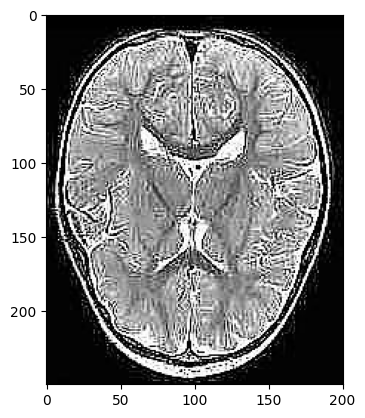

In [9]:
plt.imshow(raw_data[0][0])

In [10]:
cv2.cvtColor(raw_data[0][0], cv2.COLOR_BGR2GRAY)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], shape=(250, 201), dtype=uint8)

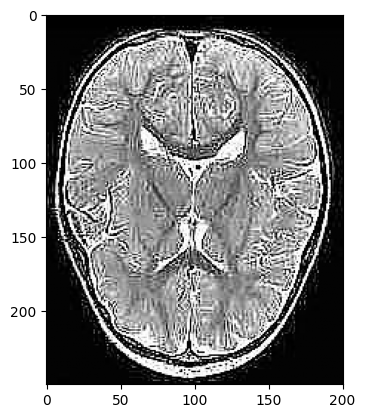

In [11]:
plt.imshow(cv2.cvtColor(raw_data[0][0], cv2.COLOR_BGR2GRAY), cmap='gray')

In [12]:
def count_shape(raw_data):
    shapes = {
        "nb_pix":[],
        "width": [],
        "height": [],
        "colors": [],
        "class": []
             }
    for i in range(0,len(raw_data)):
        dim = raw_data[i][0].shape
        lbl = raw_data[i][1]
        for key, i in zip(shapes.keys(), range(len(shapes.keys()))):
            if i == 0:
                shapes[key].append(dim[0]*dim[1])
            elif i == 4:
                shapes[key].append(lbl)
            else:
                shapes[key].append(dim[i-1])

    return pd.DataFrame.from_dict(shapes)

In [13]:
df_shapes = count_shape(raw_data)

In [14]:
df_shapes.value_counts()

nb_pix   width  height  colors  class
262144   512    512     3       3        1418
                                1        1321
                                2        1199
50625    225    225     3       0         260
396900   630    630     3       0          77
                                         ... 
63736    248    257     3       2           1
63720    270    236     3       0           1
63288    293    216     3       0           1
63248    268    236     3       0           1
2073600  1080   1920    3       0           1
Name: count, Length: 394, dtype: int64

nb_pix
262144    3955
50625      268
396900      77
50400       71
55696       53
          ... 
554400       1
47436        1
224664       1
112671       1
136080       1
Name: count, Length: 368, dtype: int64
width
512    3962
225     277
236      79
630      77
442      72
       ... 
344       1
450       1
781       1
488       1
378       1
Name: count, Length: 230, dtype: int64
height
512    3955
225     270
236     145
630      79
201      73
       ... 
421       1
446       1
237       1
456       1
360       1
Name: count, Length: 199, dtype: int64
colors
3    5712
Name: count, dtype: int64
class
0    1595
3    1457
2    1339
1    1321
Name: count, dtype: int64


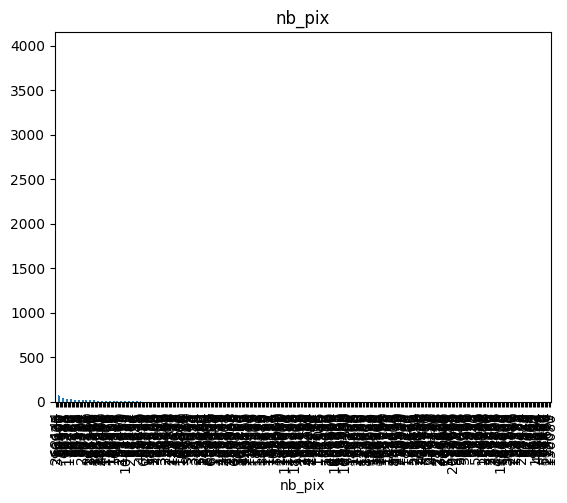

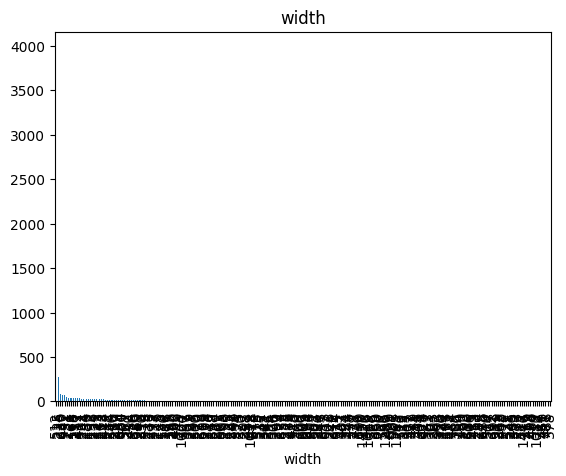

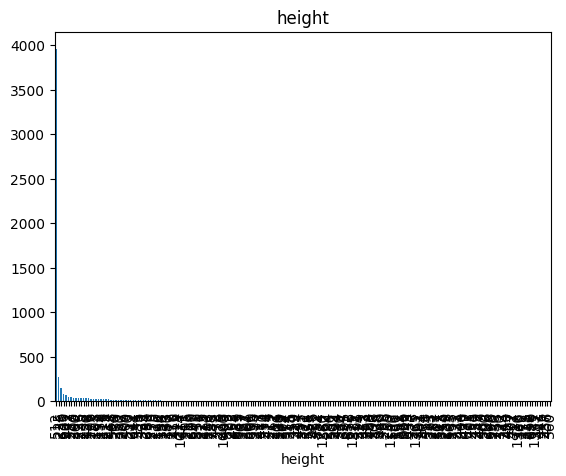

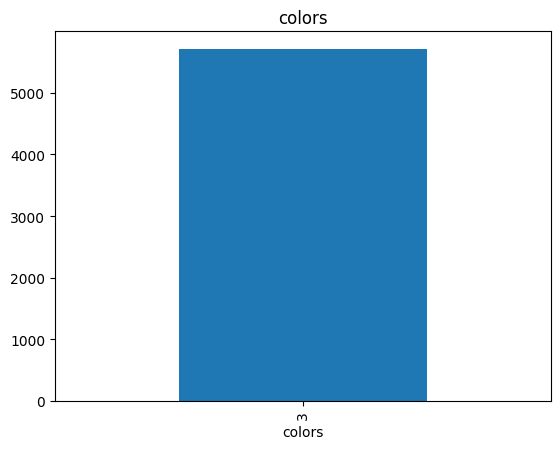

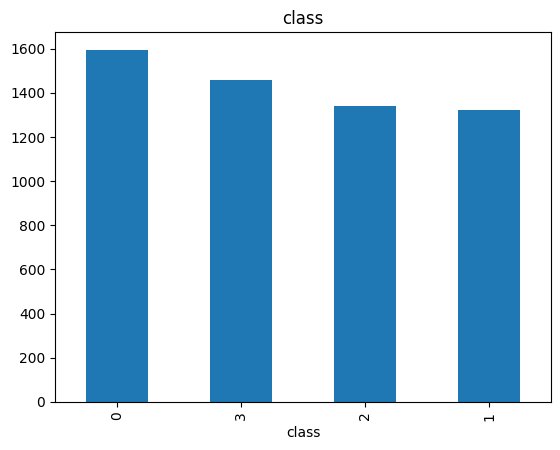

In [15]:
for col in df_shapes.columns:
    plt.figure()
    count = df_shapes[col].value_counts()
    print(count)
    count.plot.bar()
    plt.title(col)

In [16]:
def get_index_by_class(raw_data, classes):
    index_classes = {}
    for c in classes:
        index_classes[c] = []

    for i in range(0, len(raw_data)):
        c = classes[raw_data[i][1]]
        index_classes[c].append(i)

    return index_classes

In [17]:
index_classes = get_index_by_class(raw_data, CLASSES)
#index_classes

### Content

#### Target visualization

In [18]:
def count_label(raw_data, classes):
    count_lbl = {}
    for lbl in classes:
        count_lbl[lbl] = 0

    for i in range(0, len(raw_data)):
        lbl = raw_data[i][1]
        count_lbl[classes[lbl]] += 1

    return count_lbl

In [19]:
count_label(raw_data, CLASSES)

{'notumor': 1595, 'glioma': 1321, 'meningioma': 1339, 'pituitary': 1457}

#### Images orientation

In [20]:
def check_orientation(df_shapes, classes):
    orientation_count = {}
    for elm in (['total'] + classes):
        orientation_count[elm] = {
            'portrait': 0,
            'landscape': 0,
            'square': 0,
        }

    for index, row in df_shapes.iterrows():
        w = row['width']
        h = row['height']
        c = classes[row['class']]
        if h > w:
            orientation = 'portrait'
        elif h < w:
            orientation = 'landscape'
        else:
            orientation = 'square'
        orientation_count['total'][orientation] += 1
        orientation_count[c][orientation] += 1

    return orientation_count

In [21]:
orientation_count = check_orientation(df_shapes, CLASSES)
orientation_count

{'total': {'portrait': 389, 'landscape': 829, 'square': 4494},
 'notumor': {'portrait': 355, 'landscape': 735, 'square': 505},
 'glioma': {'portrait': 0, 'landscape': 0, 'square': 1321},
 'meningioma': {'portrait': 30, 'landscape': 91, 'square': 1218},
 'pituitary': {'portrait': 4, 'landscape': 3, 'square': 1450}}

In [22]:
"""
for label in orientation_count:
    plt.figure()
    plt.bar(*zip(*orientation_count[label].items()))
    plt.title(label)
"""

'\nfor label in orientation_count:\n    plt.figure()\n    plt.bar(*zip(*orientation_count[label].items()))\n    plt.title(label)\n'

#### Images view

In [23]:
def estimate_MRI_view(df_shapes, classes):
    orientation_count = {}
    for elm in (['total'] + classes):
        orientation_count[elm] = {
            'axial': 0,
            'sagittal': 0,
            'coronal': 0,
        }

    for index, row in df_shapes.iterrows():
        w = row['width']
        h = row['height']
        c = classes[row['class']]
        if h/w > 1.2 :
            orientation = 'sagittal'
        elif h/w < 0.8 :
            orientation = 'coronal'
        else:
            orientation = 'axial'
        orientation_count['total'][orientation] += 1
        orientation_count[c][orientation] += 1

    return orientation_count

In [24]:
view_count = estimate_MRI_view(df_shapes, CLASSES)
view_count

{'total': {'axial': 5448, 'sagittal': 103, 'coronal': 161},
 'notumor': {'axial': 1350, 'sagittal': 95, 'coronal': 150},
 'glioma': {'axial': 1321, 'sagittal': 0, 'coronal': 0},
 'meningioma': {'axial': 1322, 'sagittal': 7, 'coronal': 10},
 'pituitary': {'axial': 1455, 'sagittal': 1, 'coronal': 1}}

In [25]:
"""
for label in view_count:
    plt.figure()
    plt.bar(*zip(*view_count[label].items()))
    plt.title(label)
"""

'\nfor label in view_count:\n    plt.figure()\n    plt.bar(*zip(*view_count[label].items()))\n    plt.title(label)\n'

#### Images intensity

In [5]:
def compute_intensity_stats(raw_data, classes):
    records = []

    for i in tqdm.tqdm(range(0,len(raw_data))):
        img = cv2.cvtColor(raw_data[i][0], cv2.COLOR_BGR2GRAY)  # grayscale
        mean = img.mean()
        std = img.std()
        min_val = img.min()
        max_val = img.max()

        img_flat = raw_data[i][0].flatten()
        skew_v = float(skew(img_flat)) # is image contains more light/dark area ?
        kurt_v = float(kurtosis(img_flat)) # is image contains area with high intensity ?

        records.append({
            "class": classes[raw_data[i][1]],
            "mean": mean,
            "std": std,
            "min": min_val,
            "max": max_val,
            "skew": skew_v,
            "kurt": kurt_v
        })

    return pd.DataFrame(records)

In [27]:
df_intensity = compute_intensity_stats(raw_data, CLASSES)
df_intensity

class        mean        std  min  max
0       notumor  108.471164  93.001929    0  255
1       notumor   83.985305  72.359165    0  243
2       notumor   50.655235  47.153861    0  251
3       notumor  120.912172  57.199174    0  255
4       notumor   30.839504  58.445578    0  255
...         ...         ...        ...  ...  ...
5707  pituitary   50.346027  41.824164    0  253
5708  pituitary   51.874092  43.663335    0  255
5709  pituitary   38.698360  40.226103    0  255
5710  pituitary   59.524090  47.755036    0  255
5711  pituitary   39.137924  48.103363    0  255

[5712 rows x 5 columns]

In [28]:
df_intensity_raw = df_intensity.copy(deep=True)

In [29]:
def detect_brightness_outliers(df, z_thresh=2.576):
    """
    Outliers are detected based on the average brightness.
    z_thresh: threshold in standard deviation
    """
    mu = df["mean"].mean()
    sigma = df["mean"].std()
    df["zscore"] = (df["mean"] - mu) / sigma
    
    return df[(df["zscore"].abs() > z_thresh)]

In [30]:
df_brightness = detect_brightness_outliers(df_intensity)
df_brightness

class        mean        std  min  max    zscore
0        notumor  108.471164  93.001929    0  255  3.463690
3        notumor  120.912172  57.199174    0  255  4.167923
42       notumor   96.171753  77.672590    0  255  2.767472
82       notumor  101.820742  50.273700   29  255  3.087237
83       notumor   97.030121  79.925613    0  255  2.816060
...          ...         ...        ...  ...  ...       ...
4105  meningioma   93.825469  75.990780    0  255  2.634658
4114  meningioma  104.109175  60.835063   18  255  3.216776
4134  meningioma   93.113179  39.650765   32  255  2.594339
4213  meningioma  108.115605  87.363928    0  255  3.443563
4397   pituitary  102.333716  60.426596    0  255  3.116274

[181 rows x 6 columns]

In [31]:
def plot_outliers_histo(df_outliers, classes):
    res = {}
    for elm in classes:
        tmp = df_outliers[df_outliers['class'] == elm]
        res[elm] = len(tmp.index)

    plt.figure()
    bar_cntnr = plt.bar(*zip(*res.items()))
    plt.bar_label(bar_cntnr, label=res.values())

    return res


def plot_outliers_ratio(df_outliers, classes, df_intensity):
    res = plot_outliers_histo(df_outliers, classes)

    for elm in res:
        tmp = df_intensity[df_intensity['class'] == elm]
        total = len(tmp.index)
        res[elm] = f'{res[elm]}/{total} ({round(res[elm]/total*100, 2)}%)'

    return res

{'notumor': '158/1595 (9.91%)',
 'glioma': '0/1321 (0.0%)',
 'meningioma': '22/1339 (1.64%)',
 'pituitary': '1/1457 (0.07%)'}

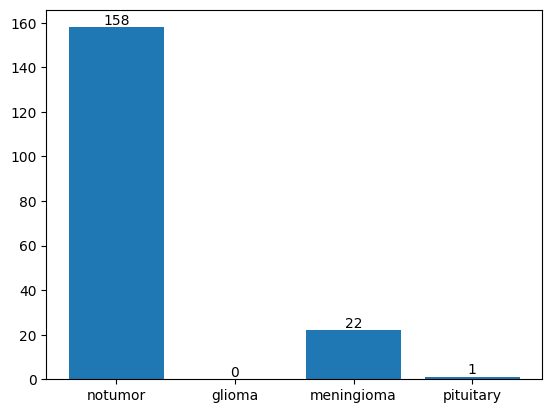

In [32]:
plot_outliers_ratio(df_brightness, CLASSES, df_intensity)

In [33]:
def mean_intensity_per_class(df_intensity):
    df_mi = df_intensity.groupby("class")[["mean", "std"]].mean()    
    return df_mi

def z_test_pairwise(df_intensity, p_thresh=0.05):
    df_mi = mean_intensity_per_class(df_intensity)
    df_mi['n'] = df_intensity.groupby("class")['mean'].count()

    stat_diff = {'class_1':[], 'class_2': [], 'pval': []}
    labels = df_mi.index.to_list()
    for i in range(0, len(labels)):
        for j in range(i+1, len(labels)):
            m1 = df_mi.loc[labels[i],"mean"]
            s1 = df_mi.loc[labels[i],"std"]
            n1 = df_mi.loc[labels[i],"n"]
            m2 = df_mi.loc[labels[j],"mean"]
            s2 = df_mi.loc[labels[j],"std"]
            n2 = df_mi.loc[labels[j],"n"]
            z = (m1-m2) / np.sqrt(s1*s1/n1 + s2*s2/n2)
            pval = norm.sf(abs(z))
            if pval > p_thresh:
                stat_diff['class_1'].append(labels[i])
                stat_diff['class_2'].append(labels[j])
                stat_diff['pval'].append(pval)
                
                
    return df_mi, pd.DataFrame.from_dict(stat_diff)

In [34]:
df_mi, df_diff = z_test_pairwise(df_intensity)

In [35]:
df_mi

mean        std     n
class                                 
glioma      32.711430  38.325023  1321
meningioma  43.482108  46.733826  1339
notumor     60.723721  60.561156  1595
pituitary   49.267893  41.403495  1457

In [36]:
df_diff

Empty DataFrame
Columns: [class_1, class_2, pval]
Index: []

#### Pixel variances per class

In [37]:
def variance_analysis(df):
    return df.groupby("class")["std"].mean()

In [38]:
variance_analysis(df_intensity)

class
glioma        38.325023
meningioma    46.733826
notumor       60.561156
pituitary     41.403495
Name: std, dtype: float64

In [39]:
def pairwise_variance_tests(df):
    classes = df["class"].unique()
    stat_diff = {'class_1':[], 'class_2': [], 'pval': []}
    for c1, c2 in combinations(classes, 2):
        stat, pval = levene(df[df["class"]==c1]["std"],
                               df[df["class"]==c2]["std"])
        stat_diff['class_1'].append(c1)
        stat_diff['class_2'].append(c2)
        stat_diff['pval'].append(pval)

    return pd.DataFrame.from_dict(stat_diff)

In [40]:
pairwise_variance_tests(df_intensity)

class_1     class_2           pval
0     notumor      glioma  4.604856e-209
1     notumor  meningioma  6.191060e-158
2     notumor   pituitary  5.703957e-273
3      glioma  meningioma   2.413494e-03
4      glioma   pituitary   9.134318e-13
5  meningioma   pituitary   2.808915e-16

Variance differencies are really importants -> need to normalize and crop borders

In [41]:
def show_samples(raw_data, index_classes, classes, samples=None):
    already_sample = True
    if samples == None:
        samples = {}
        already_sample = False
    for cls in classes:
        if not already_sample:
            sample = random.sample(index_classes[cls], 10)
            samples[cls] = sample
        else:
            sample = samples[cls]

        plt.figure(figsize=(12,4))
        for i,i_img in enumerate(sample):
            img = img = raw_data[i_img][0]
            plt.subplot(1,10,i+1)
            plt.imshow(img if img.ndim==2 else cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f'{cls} \nn°{i_img}')
            plt.axis("off")

        
        for i_img in sample:
            img = raw_data[i_img][0]
            plt.imshow(img)
    return samples

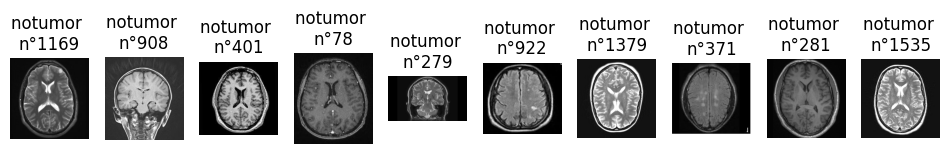

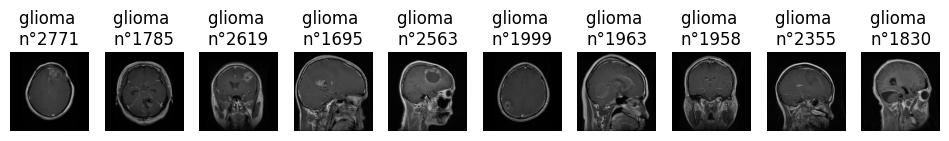

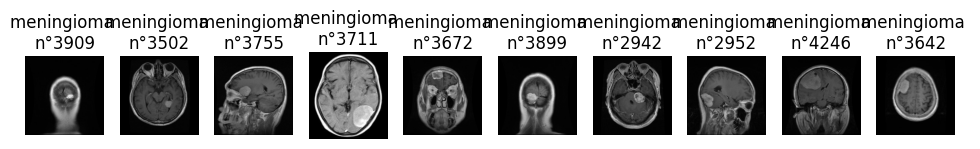

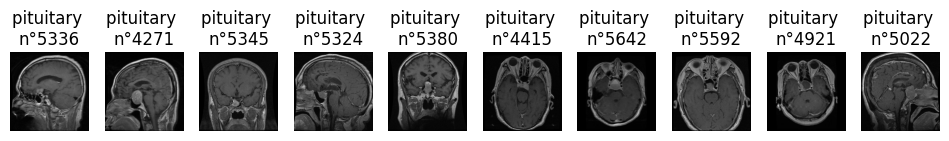

In [42]:
samples_to_keep = show_samples(raw_data, index_classes, CLASSES)

In [43]:
def center_crop(img, crop_ratio=0.7):
    h, w = img.shape[:2]
    new_h, new_w = int(h * crop_ratio), int(w * crop_ratio)
    start_h = (h - new_h) // 2
    start_w = (w - new_w) // 2
    return img[start_h:start_h+new_h, start_w:start_w+new_w]

def crop_black_background(img, thresh=10):
    # 1. Convert to grayscale if needed
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img

    # 2. Trouver les pixels > seuil
    mask = gray > thresh
    coords = np.argwhere(mask)  # pixels non noirs

    if coords.size == 0:  # sécurité
        return img

    # 3. Bounding box autour du cerveau
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)

    return img[y0:y1, x0:x1]

def crop_brain_roi(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
    
    # Flou pour réduire bruit
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Seuillage automatique
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Trouver le plus grand contour
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    biggest = max(contours, key=cv2.contourArea)

    # Rectangle autour du plus gros contour
    x, y, w, h = cv2.boundingRect(biggest)
    return img[y:y+h, x:x+w]

In [44]:
def show_all_crop_methods(img, img_name=""):
    imgs = {
        "original": img,
        "center_crop": center_crop(img),
        "black_crop": crop_black_background(img),
        "roi_crop": crop_brain_roi(img)
    }
    
    plt.figure(figsize=(12,4))
    for i,(name,im) in enumerate(imgs.items()):
        plt.subplot(1,4,i+1)
        plt.imshow(im if im.ndim==2 else cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.title(name + "_" + img_name)
        plt.axis("off")

In [45]:
"""
for cls in CLASSES:
    sample = random.sample(index_classes[cls], 20)
    for i_img in sample:
        img = raw_data[i_img][0]
        show_all_crop_methods(img, cls)
"""

'\nfor cls in CLASSES:\n    sample = random.sample(index_classes[cls], 20)\n    for i_img in sample:\n        img = raw_data[i_img][0]\n        show_all_crop_methods(img, cls)\n'

**Black crop** method is better

In [46]:
for i in tqdm.tqdm(range(0, len(raw_data))):
    raw_data[i] = (crop_black_background(raw_data[i][0]), raw_data[i][1])

100%|██████████| 5712/5712 [00:08<00:00, 700.62it/s] 


In [47]:
def get_size_thrshld(size, trsh_lst=[124, 224, 324]):
    for thrsh in trsh_lst:
        if size < thrsh:
            return f'< {thrsh}'
    return f'> {thrsh}'

def get_ratio_size_thrsh(size_dct):
    total = np.sum(list(size_dct.values()))
    res = {}
    for thrsh in sorted(list(size_dct.keys())):
        res[thrsh] = round(size_dct[thrsh] * 100 / total, 2)
    return res

def check_size(raw_data,trsh_lst=[124, 224, 324]):
    count_size = {'widht':{}, 'height':{}}

    for i in range(0, len(raw_data)):
        sizes = raw_data[i][0].shape
        height = get_size_thrshld(sizes[0], trsh_lst)
        widht = get_size_thrshld(sizes[1], trsh_lst)
        
        if height not in count_size['height']:
            count_size['height'][height] = 1
        else:
            count_size['height'][height] += 1
            
        if widht not in count_size['widht']:
            count_size['widht'][widht] = 1
        else:
            count_size['widht'][widht] += 1

    for key in count_size:
        count_size[key] = get_ratio_size_thrsh(count_size[key])
        
    return count_size

In [48]:
check_size(raw_data)

{'widht': {'< 124': np.float64(0.02),
  '< 224': np.float64(15.23),
  '< 324': np.float64(8.09),
  '> 324': np.float64(76.66)},
 'height': {'< 224': np.float64(9.82),
  '< 324': np.float64(12.48),
  '> 324': np.float64(77.7)}}

In [49]:
check_size(raw_data, [156,256,356])

{'widht': {'< 156': np.float64(2.56),
  '< 256': np.float64(18.28),
  '< 356': np.float64(8.7),
  '> 356': np.float64(70.47)},
 'height': {'< 156': np.float64(0.18),
  '< 256': np.float64(18.28),
  '< 356': np.float64(6.11),
  '> 356': np.float64(75.44)}}

In [50]:
def resize_img(img):
    return cv2.resize(img, (260, 260))

In [51]:
for i in tqdm.tqdm(range(0, len(raw_data))):
    raw_data[i] = (resize_img(raw_data[i][0]), raw_data[i][1])

100%|██████████| 5712/5712 [00:01<00:00, 5408.69it/s]


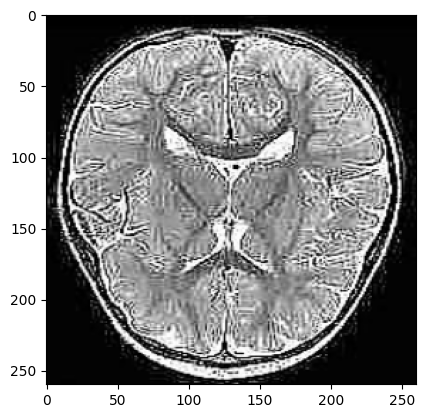

In [52]:
plt.imshow(raw_data[0][0])

In [53]:
def normalize_image(img):
    img = img.astype(np.float32)
    img = (img - np.mean(img)) / np.std(img)
    return img

In [54]:
for i in tqdm.tqdm(range(0, len(raw_data))):
    raw_data[i] = (normalize_image(raw_data[i][0]), raw_data[i][1])

100%|██████████| 5712/5712 [00:03<00:00, 1817.40it/s]


In [55]:
#raw_data[0][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3095372..1.7328129].


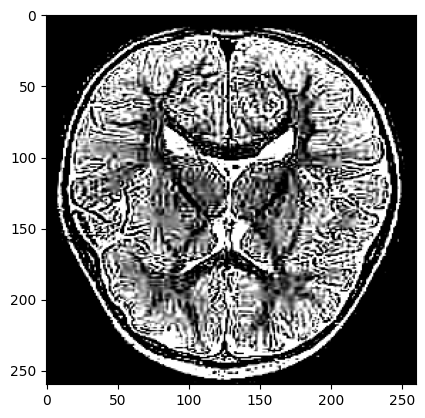

In [56]:
plt.imshow(raw_data[0][0])

In [79]:
def get_global_intensity_distrib(raw_data, nb_deci=4):
    distrib = {}
    for i in tqdm.tqdm(range(0, len(raw_data))):
        unique, counts = np.unique(raw_data[i][0].flatten(), return_counts=True)
        for val, count in zip(unique, counts):
            val = round(val, nb_deci)
            if val not in distrib:
                distrib[val] = count
            else:
                distrib[val] += count
    return OrderedDict(sorted(distrib.items()))

In [80]:
distrib = get_global_intensity_distrib(raw_data)

100%|██████████| 5712/5712 [00:32<00:00, 173.56it/s]


In [73]:
#distrib

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3095372..1.7328129].


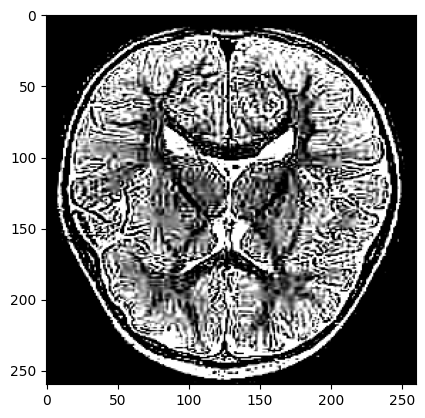

In [60]:
plt.imshow(raw_data[0][0])

Text(0.5, 1.0, 'Normalized intensity distribution')

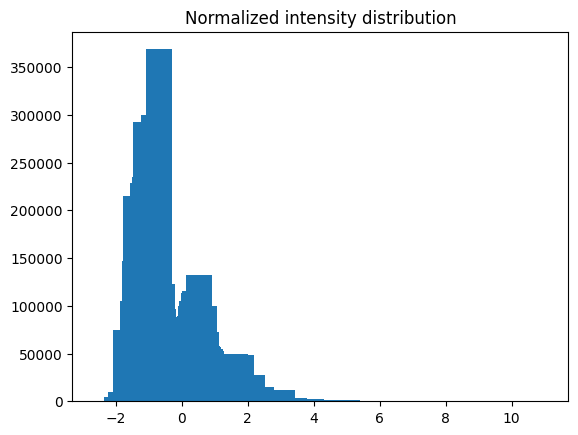

In [81]:
plt.figure()
bar_cntnr = plt.bar(*zip(*distrib.items()))
#plt.bar_label(bar_cntnr, label=res.values())
plt.title("Normalized intensity distribution")

In [82]:
def get_percentiles_from_distrib(distrib, low_bound=0.01, high_bound=0.99):
    pixel_vals = np.array(list(distrib.keys()))
    counts = np.array(list(distrib.values()))
    
    # create a frequency vector (without storing everything)
    frequency_v = np.cumsum(counts) / counts.sum()
    
    # find the p1=1% and p99=99% thresholds
    low_val = pixel_vals[np.searchsorted(frequency_v, low_bound)]
    high_val = pixel_vals[np.searchsorted(frequency_v, high_bound)]
    
    return low_val, high_val

In [83]:
low, high = get_percentiles_from_distrib(distrib)
print(f'{low}, {high}')

-1.4193999767303467, 2.883500099182129


In [86]:
img_clipped = np.clip(raw_data[0][0], low, high)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3095372..1.7328129].


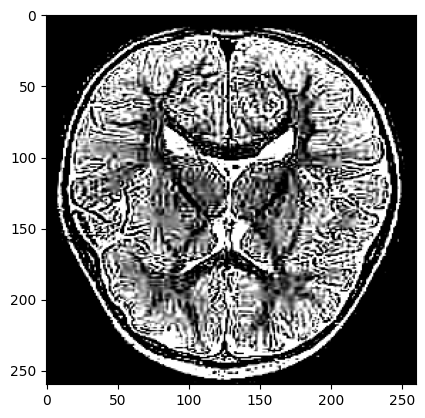

In [87]:
plt.imshow(raw_data[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3095372..1.7328129].


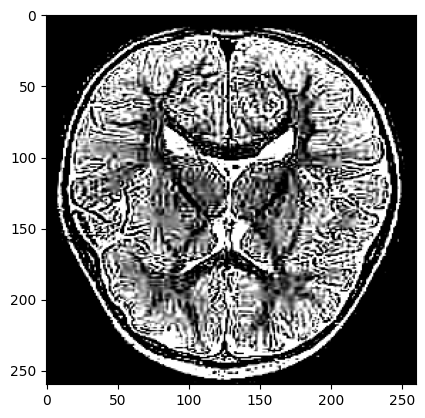

In [88]:
plt.imshow(img_clipped)

In [89]:
def clip_all_images(raw_data, distrib=None, low_bound=0.01, high_bound=0.99):
    if distrib == None:
        distrib = get_global_intensity_distrib(raw_data)
    low, high = get_percentiles_from_distrib(distrib, low_bound, high_bound)
    for i in tqdm.tqdm(range(0, len(raw_data))):
        raw_data[i] = (np.clip(raw_data[i][0], low, high), raw_data[i][1])
    return raw_data, low, high

In [90]:
cliped_data, low, high = clip_all_images(raw_data, distrib=distrib, low_bound=0.01, high_bound=0.99)
print(f'{low}, {high}')

100%|██████████| 5712/5712 [00:01<00:00, 5364.49it/s]

-1.4193999767303467, 2.883500099182129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3095372..1.7328129].


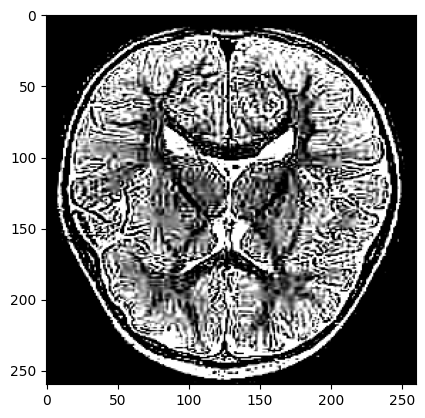

In [91]:
plt.imshow(cliped_data[0][0])

In [92]:
pairwise_variance_tests(df_intensity_raw)

class_1     class_2           pval
0     notumor      glioma  4.604856e-209
1     notumor  meningioma  6.191060e-158
2     notumor   pituitary  5.703957e-273
3      glioma  meningioma   2.413494e-03
4      glioma   pituitary   9.134318e-13
5  meningioma   pituitary   2.808915e-16

In [93]:
df_intensity_corec = compute_intensity_stats(cliped_data, CLASSES)
pairwise_variance_tests(df_intensity_corec)

class_1     class_2          pval
0     notumor      glioma  2.169937e-17
1     notumor  meningioma  9.199690e-24
2     notumor   pituitary  6.072012e-07
3      glioma  meningioma  3.829449e-03
4      glioma   pituitary  4.141421e-08
5  meningioma   pituitary  3.619781e-15

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0714155..2.8835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3643602..2.512085].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2398797..2.0762587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3879807..2.8835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96520954..2.8835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2234803..2.7302911].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.044701..2.05441

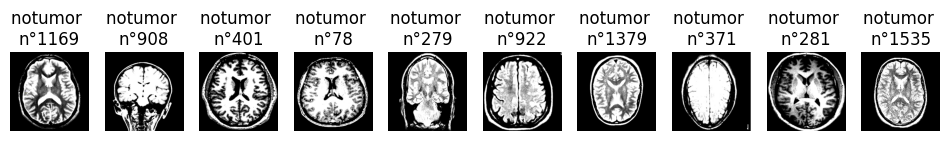

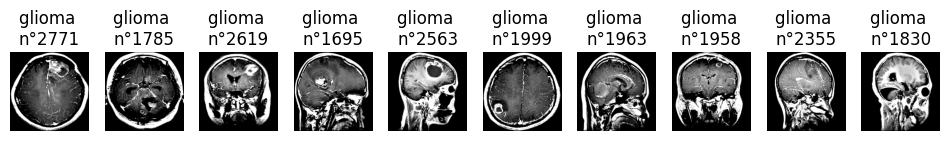

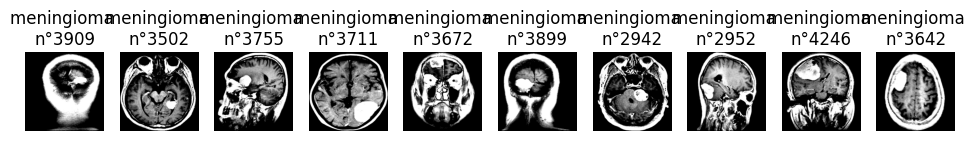

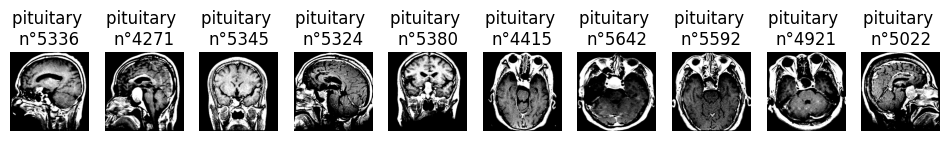

In [94]:
_ = show_samples(raw_data, index_classes, CLASSES, samples=samples_to_keep)

#### Intraclass variability

##### Before cleaning

Text(0.5, 1.0, 'Variance des intensités par classe')

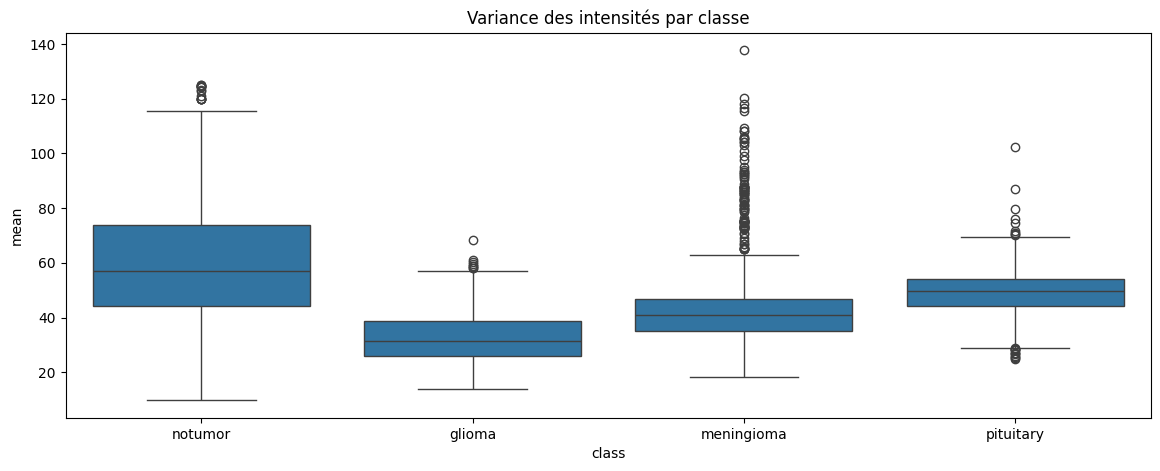

In [95]:
plt.figure(figsize=(14, 5))
sns.boxplot(data=df_intensity_raw, x="class", y="mean")
plt.title("Variance des intensités par classe")
#plt.savefig(PROJECT_ROOT / "tmp_box_plot.png")

Text(0.5, 1.0, 'Distribution intra-classe (mean intensity)')

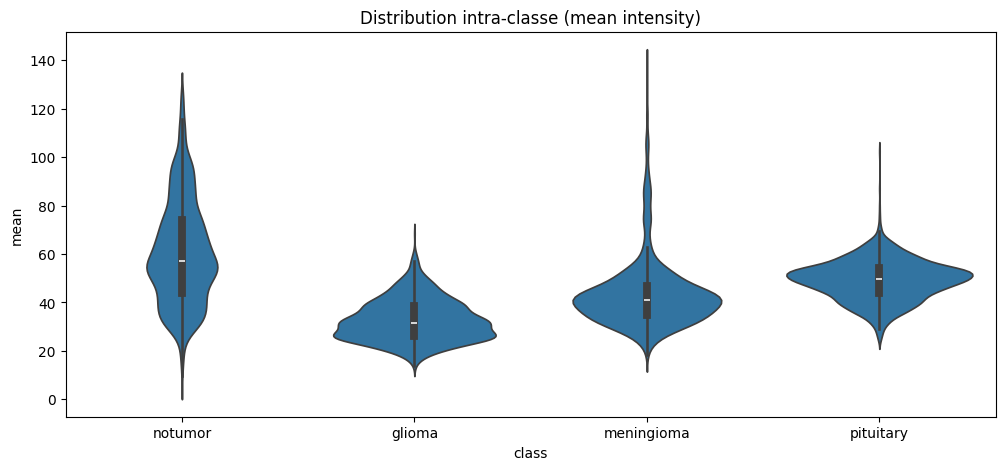

In [96]:
plt.figure(figsize=(12,5))
sns.violinplot(data=df_intensity_raw, x="class", y="mean")
plt.title("Distribution intra-classe (mean intensity)")
#plt.savefig(PROJECT_ROOT / "tmp_violin_plot.png")

##### After cleaning

Text(0.5, 1.0, 'Variance des intensités par classe')

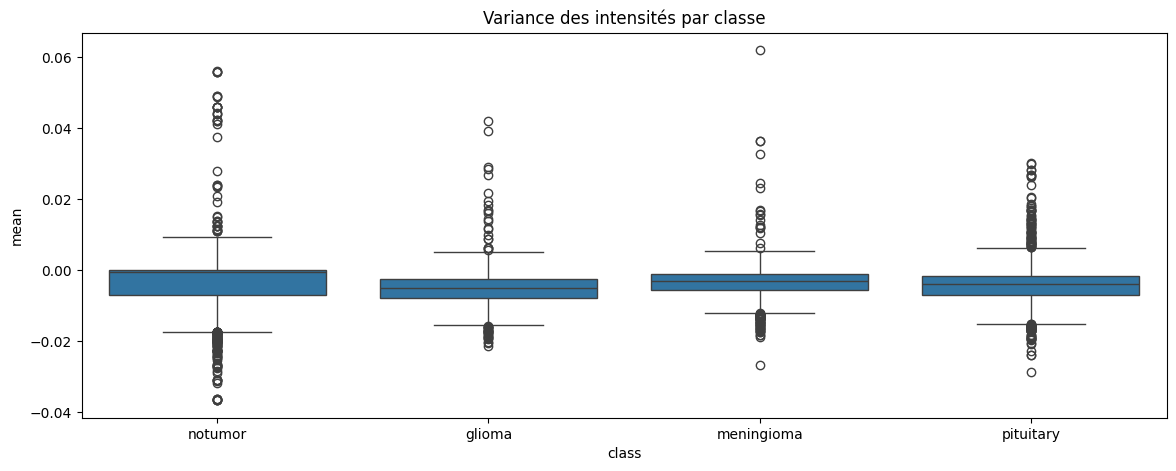

In [97]:
plt.figure(figsize=(14, 5))
sns.boxplot(data=df_intensity_corec, x="class", y="mean")
plt.title("Variance des intensités par classe")
#plt.savefig(PROJECT_ROOT / "tmp_box_plot.png")

Text(0.5, 1.0, 'Distribution intra-classe (mean intensity)')

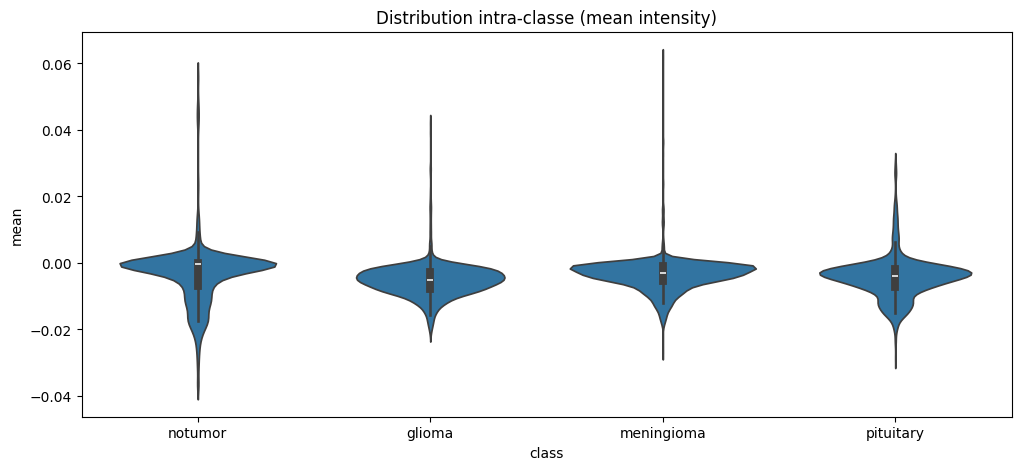

In [98]:
plt.figure(figsize=(12,5))
sns.violinplot(data=df_intensity_corec, x="class", y="mean")
plt.title("Distribution intra-classe (mean intensity)")
#plt.savefig(PROJECT_ROOT / "tmp_violin_plot.png")

##### Outliers

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4194..1.4742473].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0208267..2.8835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4194..2.8835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8124442..2.8835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4194..1.5845234].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2618581..2.8835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4194..2.581657].
Clipping i

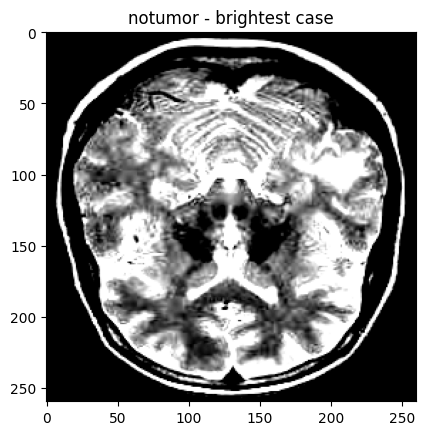

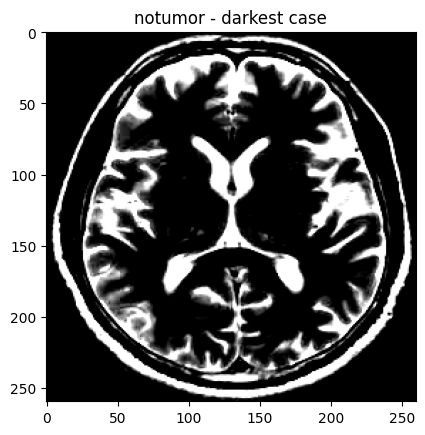

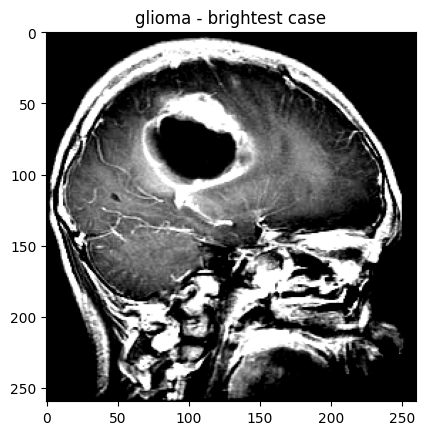

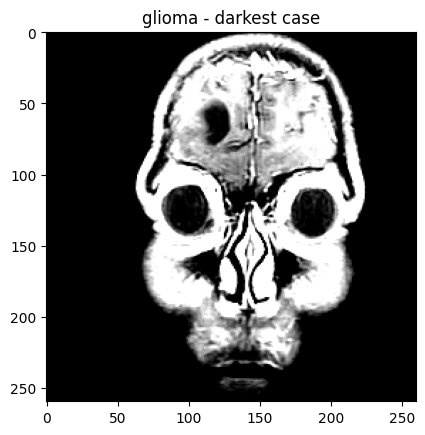

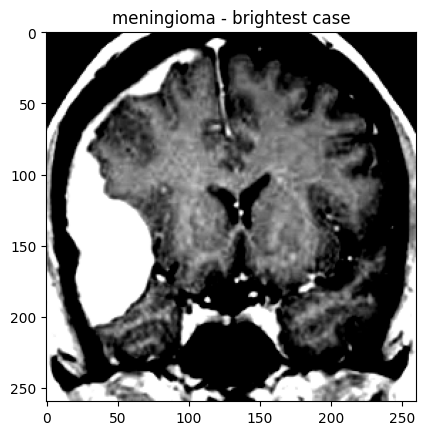

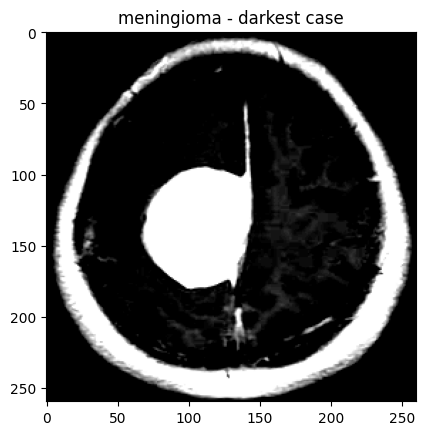

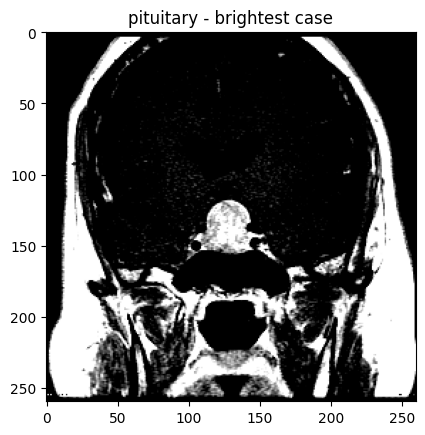

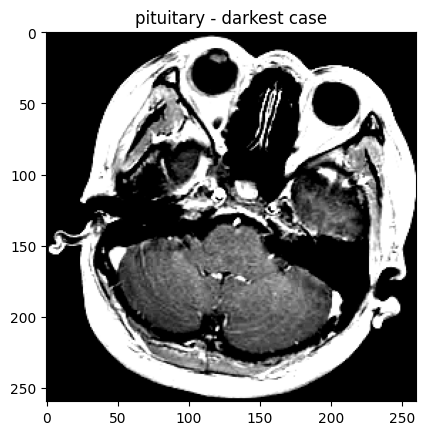

In [99]:
for cls in CLASSES:
    subset = df_intensity_raw[df_intensity_raw["class"] == cls]
    idx_max = subset["mean"].idxmax()
    idx_min = subset["mean"].idxmin()

    plt.figure()
    plt.imshow(raw_data[idx_max][0])
    plt.title(f'{cls} - brightest case')
    plt.figure()
    plt.imshow(raw_data[idx_min][0])
    plt.title(f'{cls} - darkest case')

#### PCA (to see the underlying structure)

In [6]:
df_intensity_raw = compute_intensity_stats(raw_data, CLASSES)
df_intensity_raw

100%|██████████| 5712/5712 [01:57<00:00, 48.64it/s] 


class        mean        std  min  max      skew      kurt
0       notumor  108.471164  93.001929    0  255  0.147533 -1.438233
1       notumor   83.985305  72.359165    0  243  0.169067 -1.416660
2       notumor   50.655235  47.153861    0  251  1.106338  1.401446
3       notumor  120.912172  57.199174    0  255  0.060304 -0.680373
4       notumor   30.839504  58.445578    0  255  1.969515  3.276175
...         ...         ...        ...  ...  ...       ...       ...
5707  pituitary   50.346027  41.824164    0  253  0.628991  0.087195
5708  pituitary   51.874092  43.663335    0  255  0.696921  0.195839
5709  pituitary   38.698360  40.226103    0  255  0.822303 -0.094343
5710  pituitary   59.524090  47.755036    0  255  0.604808  0.010472
5711  pituitary   39.137924  48.103363    0  255  1.087201  0.362532

[5712 rows x 7 columns]

In [9]:
def do_PCA(df_stats, pca_components=2):
    features = df_stats[["mean", "std", "skew", "kurt"]].values
    labels = df_stats["class"].values
    
    # Normalization
    scaled = StandardScaler().fit_transform(features)
    
    pca = PCA(n_components=pca_components)
    coords = pca.fit_transform(scaled)
    
    df_stats["pc1"] = coords[:, 0]
    df_stats["pc2"] = coords[:, 1]
    
    # Visualisation
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_stats, x="pc1", y="pc2", hue="class", alpha=0.5)
    plt.title("PCA on globals stats")
    plt.show()
    
    print("Explained variance :", pca.explained_variance_ratio_)

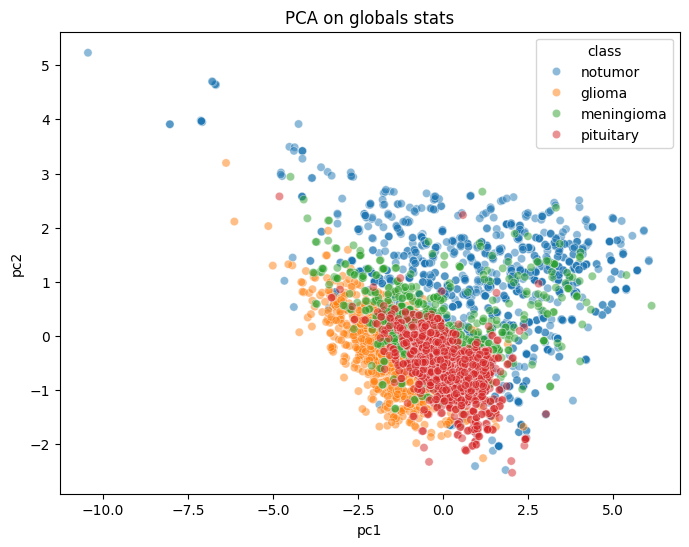

Explained variance : [0.69979915 0.21286894]


In [10]:
do_PCA(df_intensity_raw)